<a href="https://colab.research.google.com/github/dsirtioglu/python/blob/dsirtioglu-RR/RR_NL_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Netherlands' Electricity Consumption 
Using weather, population and economic output

## Import Libraries


In [84]:
import pandas as pd
import numpy as np
import copy

import matplotlib
from matplotlib import pyplot as plt

from tabulate import tabulate

In [85]:
!pip install cbsodata
import cbsodata

## Import Electricity Balance Data

Sourced from CBS Open Data Stat Line (https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=84575ENG&_theme=1029)

In [86]:
#Import Electrcity Balance data (Predicted variable: NetConsumptionCalculated_30)
info = cbsodata.get_info('84575ENG')
#print(info)

Electricity_balance = pd.DataFrame(cbsodata.get_data('84575ENG')) 

Electricity_balance[Electricity_balance['Periods'].str.contains('1979')]
##Monthly consumption data available from 1979 onwards

,ID,Periods,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30
98,98,1979 January,6124.0,248.0,5876.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,266.0,5591.0
99,99,1979 February,5358.0,220.0,5138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,230.0,4889.0
100,100,1979 March,5728.0,231.0,5497.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,246.0,5256.0
101,101,1979 1st quarter,17210.0,699.0,16511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN,NaN,NaN,NaN,743.0,15735.0
102,102,1979 April,5095.0,212.0,4883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,219.0,4661.0
103,103,1979 May,5199.0,217.0,4982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,223.0,4744.0
104,104,1979 June,4776.0,211.0,4565.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,203.0,4353.0
105,105,1979 2nd quarter,15070.0,640.0,14430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,48,NaN,NaN,NaN,NaN,NaN,645.0,13758.0
106,106,1979 July,4466.0,198.0,4268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN,187.0,4161.0
107,107,1979 August,4845.0,204.0,4641.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,205.0,4548.0


In [87]:
Electricity_balance_quarterly = copy.copy(Electricity_balance[Electricity_balance['Periods'].str.contains('quarter')])
#Electricity_balance_quarterly.head()

Electricity_balance_quarterly.insert(loc = 0,
                            column = 'Period',
                            value = Electricity_balance.Periods.str[:4] + str('Q') + Electricity_balance.Periods.str[5:6])

Electricity_balance_quarterly['Period'] = pd.PeriodIndex(Electricity_balance_quarterly['Period'], freq='Q').to_timestamp()
Electricity_balance_quarterly['NetConsumptionCalculated_30'] = Electricity_balance_quarterly.NetConsumptionCalculated_30.astype(float)
Electricity_balance_quarterly = Electricity_balance_quarterly.set_index('Period')
Electricity_balance_quarterly.tail()

,ID,Periods,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30
Period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-01,793,2019 4th quarter,32986.0,976.0,32010.0,1062.0,26763.0,5889.0,416.0,18307.0,1756.0,395.0,21.0,3527.0,2452.0,1075.0,523.0,113.0,4685,766.0,461.0,2972.0,68.0,417.0,5354,1821.0,550.0,944.0,1510.0,530.0,1343.0,29998.0
2020-01-01,798,2020 1th quarter,31796.0,875.0,30920.0,1050.0,23922.0,2694.0,433.0,18628.0,1782.0,384.0,19.0,4865.0,3656.0,1209.0,944.0,120.0,5444,602.0,1186.0,2528.0,107.0,1021.0,5274,1953.0,96.0,1720.0,1471.0,33.0,1332.0,29759.0
2020-04-01,802,2020 2th quarter,26903.0,782.0,26121.0,814.0,19332.0,1365.0,279.0,15541.0,1706.0,441.0,13.0,2371.0,1691.0,680.0,3487.0,104.0,5281,1762.0,539.0,1697.0,218.0,1065.0,5137,880.0,465.0,2543.0,1194.0,55.0,1178.0,25087.0
2020-07-01,806,2020 3th quarter,31902.0,880.0,31022.0,987.0,24307.0,2293.0,310.0,19278.0,2012.0,415.0,2.0,2667.0,1603.0,1065.0,2924.0,134.0,3689,490.0,357.0,1495.0,130.0,1217.0,6645,2016.0,491.0,3120.0,1005.0,14.0,1196.0,26869.0
2020-10-01,810,2020 4th quarter,31775.0,919.0,30857.0,1013.0,23617.0,3245.0,273.0,17400.0,2284.0,414.0,13.0,5365.0,2836.0,2529.0,699.0,149.0,5359,928.0,0.0,3027.0,86.0,1318.0,5376,2957.0,1.0,1294.0,1117.0,8.0,1347.0,29492.0


In [88]:
Electricity_balance_quarterly.dtypes

ID                                       int64
Periods                                 object
GrossProduction_1                      float64
OwnConsumptionForElectrProduction_2    float64
NetProductionTotal_3                   float64
NuclearEnergy_4                        float64
FuelsTotal_5                           float64
Coal_6                                 float64
OilProducts_7                          float64
NaturalGas_8                           float64
Biomass_9                              float64
OtherFuelsNonRenewable_10              float64
HydroPower_11                          float64
WindEnergyTotal_12                     float64
WindEnergyOnShore_13                   float64
WindEnergyOffShore_14                  float64
SolarPhotovoltaic_15                   float64
OtherSources_16                        float64
ImportsTotal_17                          int64
Belgium_18                             float64
Denmark_19                             float64
Germany_20   

In [89]:
#Update blank cells with NaN
Electricity_balance_quarterly.replace('       .', np.nan, inplace = True)
Electricity_balance_quarterly.head(50)

#Convert datatypes to float64
columns = list(Electricity_balance_quarterly)
#Electricity_balance_quarterly[columns] = Electricity_balance_quarterly[columns].astype(float)
Electricity_balance_quarterly.dtypes

ID                                       int64
Periods                                 object
GrossProduction_1                      float64
OwnConsumptionForElectrProduction_2    float64
NetProductionTotal_3                   float64
NuclearEnergy_4                        float64
FuelsTotal_5                           float64
Coal_6                                 float64
OilProducts_7                          float64
NaturalGas_8                           float64
Biomass_9                              float64
OtherFuelsNonRenewable_10              float64
HydroPower_11                          float64
WindEnergyTotal_12                     float64
WindEnergyOnShore_13                   float64
WindEnergyOffShore_14                  float64
SolarPhotovoltaic_15                   float64
OtherSources_16                        float64
ImportsTotal_17                          int64
Belgium_18                             float64
Denmark_19                             float64
Germany_20   

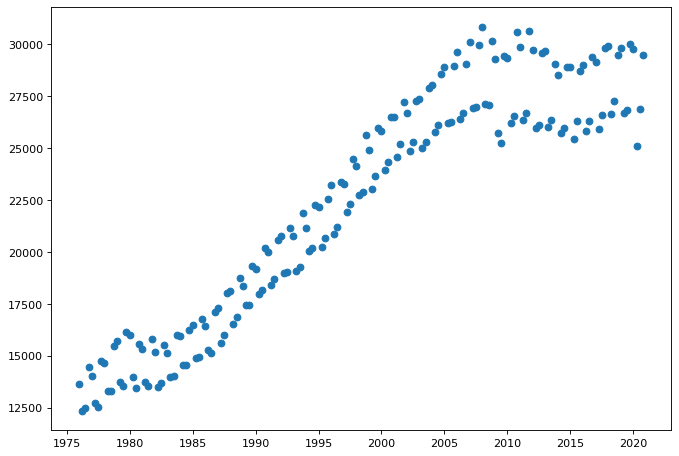

In [90]:
x = Electricity_balance_quarterly.index
y = Electricity_balance_quarterly.NetConsumptionCalculated_30

plt.scatter(x, y)
plt.show()

## Import Weather Data

Sourced from KNMI data, retrieved from Kaggle open dataset: https://www.kaggle.com/davidzaccai/knmi-19012020-historical-weather-data

In [91]:
#Input variable: Weather - KNMI data (source: https://www.kaggle.com/davidzaccai/knmi-19012020-historical-weather-data)
#Measurements taken from Station 260: De Bilt, Utrecht

url = "https://raw.githubusercontent.com/dsirtioglu/python/dsirtioglu-RR/KNMI_20200710.csv"

Weather = pd.read_csv(url)
Weather.tail(20) 
#TG: avarage daily temperature in 0.1 degrees celsius

#DDVEC: vector mean of wind direction
#FHVEC: vector mean wind speed in 0.1 m/s 
#FG: mean wind speed for a whole day in 0.1 m/s

#SQ: sunshine duration (in 0.1 hours)

#DR: duration of precipitation (in 0.1 hours)
#RH: sum of precipitation for one day (in 0.1 mm)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
43636,260,20200621,208,25,35,50,10,10,3,100,11,186,106,4,245,12,70,6,89,53,2030,0,0,0,1,10191,10213,24,10178,14,61,2,82,8,5,69,97,2,48,12,36
43637,260,20200622,285,17,23,30,8,0,24,90,13,178,110,24,224,15,76,24,135,81,2565,0,0,0,1,10248,10262,12,10216,1,56,4,82,10,2,67,96,24,42,12,45
43638,260,20200623,29,7,19,40,18,0,1,60,9,197,94,4,267,16,64,6,153,91,2914,0,0,0,1,10251,10260,8,10239,18,9,1,82,21,1,64,98,1,42,16,53
43639,260,20200624,86,33,34,50,18,10,1,90,15,233,147,2,294,14,103,6,148,88,2900,0,0,0,1,10223,10240,1,10206,18,65,1,83,19,4,52,91,1,33,12,56
43640,260,20200625,108,39,40,60,13,30,2,130,13,240,170,4,294,16,139,6,151,90,2873,0,0,0,1,10177,10207,1,10141,24,75,3,83,1,1,55,73,24,40,13,56
43641,260,20200626,146,24,31,50,9,10,23,100,11,242,190,3,301,15,153,6,128,76,2817,36,34,16,22,10110,10139,1,10086,18,24,24,82,13,3,61,98,24,35,16,55
43642,260,20200627,214,35,36,60,15,10,1,150,19,206,175,21,248,12,162,24,58,35,1663,12,21,16,7,10086,10094,23,10077,17,12,1,83,18,7,79,98,1,60,13,31
43643,260,20200628,227,51,52,70,9,30,21,140,10,179,152,24,214,16,132,24,94,56,2132,3,1,1,4,10114,10125,14,10090,1,74,11,83,23,5,60,73,3,45,17,37
43644,260,20200629,225,56,58,70,11,40,2,150,20,160,133,4,190,17,118,6,44,26,1408,0,-1,-1,1,10103,10113,11,10087,24,70,24,83,1,7,62,76,5,48,17,24
43645,260,20200630,224,49,51,70,10,20,23,150,10,160,141,6,194,13,139,6,12,7,943,82,126,28,18,10076,10086,10,10063,24,29,19,81,13,8,82,97,24,61,13,16


In [92]:
Weather.dtypes

STN          int64
YYYYMMDD     int64
DDVEC       object
FHVEC       object
FG          object
FHX         object
FHXH        object
FHN         object
FHNH        object
FXX         object
FXXH        object
TG           int64
TN           int64
TNH         object
TX           int64
TXH         object
T10N        object
T10NH       object
SQ          object
SP          object
Q           object
DR          object
RH          object
RHX         object
RHXH        object
PG          object
PX          object
PXH         object
PN          object
PNH         object
VVN         object
VVNH        object
VVX         object
VVXH        object
NG          object
UG          object
UX          object
UXH         object
UN          object
UNH         object
EV24        object
dtype: object

In [93]:
#Create Datetime from YYYYMMDD

Weather['Date'] = pd.to_datetime(Weather['YYYYMMDD'].astype(int), format = '%Y%m%d')
Weather['Year'] = Weather['Date'].dt.year.astype(str)
Weather['Quarter'] = Weather['Date'].dt.quarter.astype(str)
#Weather['Period'] = pd.PeriodIndex(Weather.Date, freq='Q')
#Weather.drop(columns = 'Period', axis=1, inplace = True)
Weather.insert(loc = 0,
                column = 'Period',
                value = Weather.Year + str('Q') + Weather.Quarter)
Weather['Period'] = pd.PeriodIndex(Weather['Period'], freq='Q').to_timestamp()
Weather.head(10)

,Period,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24,Date,Year,Quarter
0,1901-01-01,260,19010101,,,,,,,,,,-49,-65,,-24,,,,28,36,,,,,,,,,,,,,,,,66,,,,,,1901-01-01,1901,1
1,1901-01-01,260,19010102,,,,,,,,,,-18,-33,,-14,,,,0,0,,,,,,,,,,,,,,,,86,,,,,,1901-01-02,1901,1
2,1901-01-01,260,19010103,,,,,,,,,,-26,-76,,-6,,,,0,0,,,,,,,,,,,,,,,,89,,,,,,1901-01-03,1901,1
3,1901-01-01,260,19010104,,,,,,,,,,-65,-90,,-11,,,,0,0,,,,,,,,,,,,,,,,79,,,,,,1901-01-04,1901,1
4,1901-01-01,260,19010105,,,,,,,,,,-60,-82,,-20,,,,36,46,,,,,,,,,,,,,,,,65,,,,,,1901-01-05,1901,1
5,1901-01-01,260,19010106,,,,,,,,,,-100,-114,,-80,,,,61,77,,,,,,,,,,,,,,,,63,,,,,,1901-01-06,1901,1
6,1901-01-01,260,19010107,,,,,,,,,,-92,-121,,-68,,,,28,35,,,,,,,,,,,,,,,,71,,,,,,1901-01-07,1901,1
7,1901-01-01,260,19010108,,,,,,,,,,-49,-93,,-7,,,,19,24,,,,,,,,,,,,,,,,79,,,,,,1901-01-08,1901,1
8,1901-01-01,260,19010109,,,,,,,,,,11,-26,,44,,,,3,4,,,,,,,,,,,,,,,,76,,,,,,1901-01-09,1901,1
9,1901-01-01,260,19010110,,,,,,,,,,15,-15,,61,,,,39,48,,,,,,,,,,,,,,,,82,,,,,,1901-01-10,1901,1


In [94]:
#Create the quarterly average weather dataset
Weather_Quarterly = Weather.groupby(['Period'], as_index = False).mean()
Weather_Quarterly = Weather_Quarterly[Weather_Quarterly['Period'] >= '1970-01-01']
Weather_Quarterly = Weather_Quarterly.set_index('Period')
Weather_Quarterly

,STN,YYYYMMDD,TG,TN,TX
Period,,,,,
1970-01-01,260.0,1.970022e+07,15.722222,-14.733333,46.244444
1970-04-01,260.0,1.970052e+07,122.736264,72.472527,170.670330
1970-07-01,260.0,1.970081e+07,156.978261,109.521739,204.673913
1970-10-01,260.0,1.970112e+07,68.923913,36.978261,99.467391
1971-01-01,260.0,1.971022e+07,29.177778,-4.133333,59.566667
...,...,...,...,...,...
2019-07-01,260.0,2.019081e+07,172.793478,117.336957,223.032609
2019-10-01,260.0,2.019112e+07,79.391304,49.239130,109.760870
2020-01-01,260.0,2.020022e+07,67.340659,34.516484,96.153846


In [95]:
Weather_Quarterly.dtypes

STN         float64
YYYYMMDD    float64
TG          float64
TN          float64
TX          float64
dtype: object

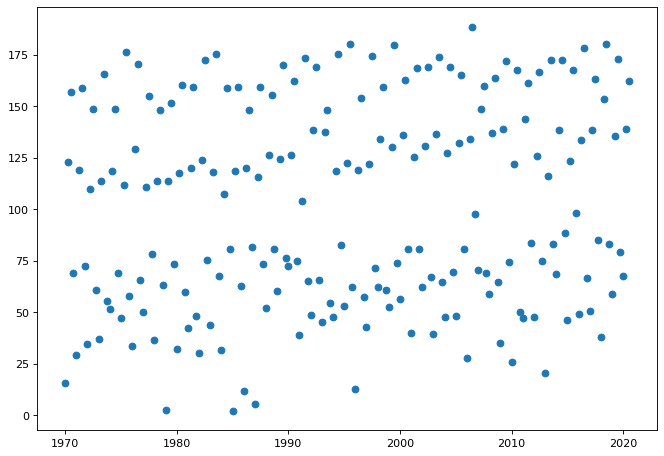

In [96]:
x = Weather_Quarterly.index
y = Weather_Quarterly.TG

plt.scatter(x, y)
plt.show()

#Add: Colors to the points grouped by months (Quarters)

## Import Economic Output Data

Sourced from https://data.oecd.org/gdp/quarterly-gdp.htm

In [97]:
#Input variable: Economic Output
#Yearly and quarterly percentage changes, all countries

url = 'https://raw.githubusercontent.com/dsirtioglu/python/dsirtioglu-RR/Quarterly%20GDP.csv'

GDP = pd.read_csv(url)
GDP.head(20) 

##Filters to be applied: 

# LOCATION = NLD
# INDICATOR = 'QGDP'
# SUBJECT = 'TOT'
# MEASURE = 'PC_CHGPP'
# FREQUENCY = 'Q' -- For quarterly values
# Flag Codes = E (?)

#Note that 'Value' field indicate the percentage change from the previous quarter in GDP


,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,OECD,QGDP,TOT,PC_CHGPP,A,1962,5.698613,NaN
1,OECD,QGDP,TOT,PC_CHGPP,A,1963,5.200710,NaN
2,OECD,QGDP,TOT,PC_CHGPP,A,1964,6.376177,NaN
3,OECD,QGDP,TOT,PC_CHGPP,A,1965,5.352664,NaN
4,OECD,QGDP,TOT,PC_CHGPP,A,1966,5.754543,NaN
5,OECD,QGDP,TOT,PC_CHGPP,A,1967,3.962032,NaN
6,OECD,QGDP,TOT,PC_CHGPP,A,1968,5.920214,NaN
7,OECD,QGDP,TOT,PC_CHGPP,A,1969,5.569769,NaN
8,OECD,QGDP,TOT,PC_CHGPP,A,1970,3.937774,NaN
9,OECD,QGDP,TOT,PC_CHGPP,A,1971,3.704789,NaN


In [98]:
GDP.dtypes

LOCATION       object
INDICATOR      object
SUBJECT        object
MEASURE        object
FREQUENCY      object
TIME           object
Value         float64
Flag Codes     object
dtype: object

In [99]:
#Apply relevant filters

GDP_NL = GDP.loc[(GDP['LOCATION'] == 'NLD') & (GDP['INDICATOR'] == 'QGDP') & (GDP['SUBJECT'] == 'TOT') & (GDP['MEASURE'] == 'PC_CHGPP') & (GDP['FREQUENCY'] == 'Q')]

GDP_NL.insert(loc = 0,
              column = 'Period',
              value = GDP_NL.TIME.str[:4] + str('Q') + GDP_NL.TIME.str[-1:])

GDP_NL['Period'] = pd.PeriodIndex(GDP_NL['Period'], freq='Q').to_timestamp()

GDP_NL = GDP_NL.set_index('Period')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [100]:
GDP_NL['Flag_negative'] = np.where(GDP_NL.Value <= 0, 1, 0)
GDP_NL.Flag_negative[GDP_NL.index > '1993-01-01'].value_counts()

0    94
1    17
Name: Flag_negative, dtype: int64

<function matplotlib.pyplot.show>

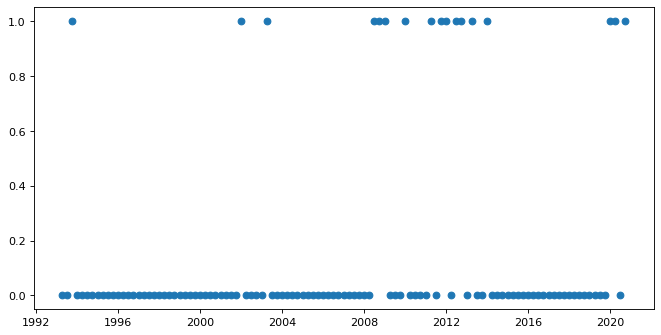

In [154]:
x = GDP_NL.index[GDP_NL.index > '1993-01-01']
y = GDP_NL.Flag_negative[GDP_NL.index > '1993-01-01']

plt.scatter(x, y)
plt.gcf().set_size_inches((10, 5))
plt.show

## Import Population data

Sourced from CBS Open Data Stat Line (https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=37296eng&_theme=1096)

In [102]:
#Import input variable: Population

POP_NL = pd.DataFrame(cbsodata.get_data('37296ENG')) 

POP_NL.head()

,ID,Periods,TotalPopulation_1,Males_2,Females_3,TotalPopulation_4,NeverMarried_5,Married_6,Widowed_7,Divorced_8,TotalPopulation_9,YoungerThan20Years_10,k_20To40Years_11,k_40To65Years_12,k_65To80Years_13,k_80YearsOrOlder_14,YoungerThan20Years_15,k_20To40Years_16,k_40To65Years_17,k_65To80Years_18,k_80YearsOrOlder_19,TotalDemographicPressure_20,GreenPressure_21,GreyPressure_22,TotalPopulation_23,Males_24,Females_25,TotalPopulation_26,PersonsWithADutchBackground_27,WithMigrationBackground_28,WithMigrationBackgroundRate_29,TotalWesternMigrationBackground_30,MiddleAndEasternEuropeanEUCountries_31,GIPSCountriesEuropeanUnion_32,OtherWesternBackground_33,TotalNonWestern_34,Morocco_35,FormerNethAntillesAndAruba_36,Suriname_37,Turkey_38,OtherNonWesternBackground_39,TotalFirstGeneration_40,TotalWesternFirstGeneration_41,MiddleAndEasternEuropeanEUCountries_42,GIPSCountriesEuropeanUnion_43,OtherWesternBackground_44,TotalNonWestern_45,Morocco_46,FormerNethAntillesAndAruba_47,Suriname_48,Turkey_49,OtherNonWesternBackground_50,TotalSecondGeneration_51,TotalWesternSecondGeneration_52,MiddleAndEasternEuropeanEUCountries_53,GIPSCountriesEuropeanUnion_54,OtherWesternBackground_55,TotalNonWestern_56,Morocco_57,FormerNethAntillesAndAruba_58,Suriname_59,Turkey_60,OtherNonWesternBackground_61,TotalPrivateHouseholds_62,OnePersonHouseholds_63,MultiPersonHouseholds_64,AverageHouseholdSize_65,PopulationInInstitutionalHouseholds_66,TotalPopulationGrowth_67,TotalPopulationGrowthRate_68,LiveBirths_69,Deaths_70,NaturalIncrease_71,NaturalIncreaseRate_72,Immigration_73,EmigrationIncludingAdministrati_74,NetMigrationIncludingAdministrativ_75,NetMigrationIncludingAdminRate_76,OtherCorrections_77,PopulationDensity_78
0,0,1950,10026773.0,4998251,5028522,10026773.0,5284496,4232241,435532,74504,10026773.0,3742499,2951369,2562311,670995,99599,37.3,29.4,25.6,6.7,1.0,81.9,67.9,14.0,30.8,30.3,31.3,10026773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2535,245,2290,3.93,NaN,173507.0,17.3,229718.0,75929.0,153789.0,15.2,70602.0,50697.0,19905.0,2.0,-187.0,309
1,1,1951,10200280.0,5083759,5116521,10200280.0,5354293,4329761,439933,76293,10200280.0,3805617,2985744,2614428,690449,104042,37.3,29.3,25.6,6.8,1.0,82.1,68.0,14.2,30.8,30.3,31.4,10200280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600,258,2342,3.88,NaN,128063.0,12.6,228407.0,77560.0,150847.0,14.7,45016.0,67449.0,-22433.0,-2.2,-351.0,315
2,2,1952,10328343.0,5145772,5182571,10328343.0,5384853,4421572,444343,77575,10328343.0,3853988,2999353,2656483,710729,107790,37.3,29.0,25.7,6.9,1.0,82.6,68.1,14.5,31.0,30.4,31.5,10328343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2658,270,2388,3.84,NaN,107288.0,10.4,231888.0,76346.0,155542.0,15.0,33666.0,81347.0,-47681.0,-4.6,-573.0,319
3,3,1953,10435631.0,5198033,5237598,10435631.0,5409984,4497526,449090,79031,10435631.0,3894738,2996594,2700881,729809,113609,37.3,28.7,25.9,7.0,1.1,83.2,68.4,14.8,31.1,30.5,31.6,10435631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2716,282,2434,3.79,NaN,115106.0,11.0,227964.0,80901.0,147063.0,14.0,35449.0,67080.0,-31631.0,-3.0,-326.0,322
4,4,1954,10550737.0,5256108,5294629,10550737.0,5443474,4572974,454436,79853,10550737.0,3945330,2994204,2744425,747436,119342,37.4,28.4,26.0,7.1,1.1,83.9,68.8,15.1,31.2,30.6,31.7,10550737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2794,297,2497,3.73,NaN,129286.0,12.3,228173.0,79623.0,148550.0,14.0,42418.0,61368.0,-18950.0,-1.8,-314.0,325


In [103]:
#Apply relevant filters

POP_NL['Period'] = POP_NL['Periods'].astype(str) + str('Q4')
POP_NL['Period'] = pd.PeriodIndex(POP_NL['Period'], freq='Q').to_timestamp()
POP_NL = POP_NL.set_index('Period')
POP_NL.tail(10)

,ID,Periods,TotalPopulation_1,Males_2,Females_3,TotalPopulation_4,NeverMarried_5,Married_6,Widowed_7,Divorced_8,TotalPopulation_9,YoungerThan20Years_10,k_20To40Years_11,k_40To65Years_12,k_65To80Years_13,k_80YearsOrOlder_14,YoungerThan20Years_15,k_20To40Years_16,k_40To65Years_17,k_65To80Years_18,k_80YearsOrOlder_19,TotalDemographicPressure_20,GreenPressure_21,GreyPressure_22,TotalPopulation_23,Males_24,Females_25,TotalPopulation_26,PersonsWithADutchBackground_27,WithMigrationBackground_28,WithMigrationBackgroundRate_29,TotalWesternMigrationBackground_30,MiddleAndEasternEuropeanEUCountries_31,GIPSCountriesEuropeanUnion_32,OtherWesternBackground_33,TotalNonWestern_34,Morocco_35,FormerNethAntillesAndAruba_36,Suriname_37,Turkey_38,OtherNonWesternBackground_39,TotalFirstGeneration_40,TotalWesternFirstGeneration_41,MiddleAndEasternEuropeanEUCountries_42,GIPSCountriesEuropeanUnion_43,OtherWesternBackground_44,TotalNonWestern_45,Morocco_46,FormerNethAntillesAndAruba_47,Suriname_48,Turkey_49,OtherNonWesternBackground_50,TotalSecondGeneration_51,TotalWesternSecondGeneration_52,MiddleAndEasternEuropeanEUCountries_53,GIPSCountriesEuropeanUnion_54,OtherWesternBackground_55,TotalNonWestern_56,Morocco_57,FormerNethAntillesAndAruba_58,Suriname_59,Turkey_60,OtherNonWesternBackground_61,TotalPrivateHouseholds_62,OnePersonHouseholds_63,MultiPersonHouseholds_64,AverageHouseholdSize_65,PopulationInInstitutionalHouseholds_66,TotalPopulationGrowth_67,TotalPopulationGrowthRate_68,LiveBirths_69,Deaths_70,NaturalIncrease_71,NaturalIncreaseRate_72,Immigration_73,EmigrationIncludingAdministrati_74,NetMigrationIncludingAdministrativ_75,NetMigrationIncludingAdminRate_76,OtherCorrections_77,PopulationDensity_78
Period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-10-01,61,2011,16655799.0,8243482,8412317,16655799.0,7773306,6864966,866497,1151030,16655799.0,3913819,4162599,5984435,1927399,667547,23.5,25.0,35.9,11.6,4.0,64.1,38.6,25.6,40.3,39.4,41.3,16655799,13228780.0,3427019.0,20.6,1527774.0,144312.0,110950.0,1272512.0,1899245.0,355883.0,141345.0,344734.0,388967.0,668316.0,1735217.0,665865.0,108701.0,62621.0,494543.0,1069352.0,167607.0,81968.0,184453.0,197042.0,438282.0,1691802.0,861909.0,35611.0,48329.0,777969.0,829893.0,188276.0,59377.0,160281.0,191925.0,230034.0,7444,2708,4736,2.21,219.0,74549.0,4.5,180060.0,135741.0,44319.0,2.7,162962.0,133194.0,29768.0,1.8,462.0,494
2012-10-01,62,2012,16730348.0,8282871,8447477,16730348.0,7841334,6851016,865790,1172208,16730348.0,3894754,4141893,5977333,2030353,686015,23.3,24.8,35.7,12.1,4.1,65.3,38.5,26.8,40.6,39.6,41.5,16730348,13236155.0,3494193.0,20.9,1556542.0,164667.0,115117.0,1276758.0,1937651.0,362954.0,143992.0,346797.0,392923.0,690985.0,1772204.0,690203.0,126307.0,65889.0,498007.0,1082001.0,168214.0,82693.0,183752.0,197107.0,450235.0,1721989.0,866339.0,38360.0,49228.0,778751.0,855650.0,194740.0,61299.0,163045.0,195816.0,240750.0,7513,2762,4751,2.20,219.0,49227.0,2.9,175959.0,140813.0,35146.0,2.1,158374.0,144491.0,13883.0,0.8,198.0,496
2013-10-01,63,2013,16779575.0,8307339,8472236,16779575.0,7895899,6823832,864180,1195664,16779575.0,3870773,4120358,5964099,2121525,702820,23.1,24.6,35.5,12.6,4.2,66.4,38.4,28.0,40.8,39.9,41.7,16779575,13236494.0,3543081.0,21.1,1576986.0,179482.0,120390.0,1277114.0,1966095.0,368838.0,145499.0,347631.0,395302.0,708825.0,1793189.0,706512.0,138187.0,70250.0,498075.0,1086677.0,168117.0,82476.0,182342.0,196203.0,457539.0,1749892.0,870474.0,41295.0,50140.0,779039.0,879418.0,200721.0,63023.0,165289.0,199099.0,251286.0,7569,2802,4767,2.19,215.0,49714.0,3.0,171341.0,141245.0,30096.0,1.8,164772.0,145669.0,19103.0,1.1,515.0,498
2014-10-01,64,2014,16829289.0,8334385,8494904,16829289.0,7956499,6787029,863292,1222469,16829289.0,3846040,4117652,5946573,2201935,717089,22.9,24.5,35.3,13.1,4.3,67.2,38.2,29.0,41.0,40.1,41.9,16829289,13234545.0,3594744.0,21.4,1597160.0,209005.0,125890.0,1262265.0,1997584.0,374996.0,146855.0,348291.0,396414.0,731028.0,1818497.0,72

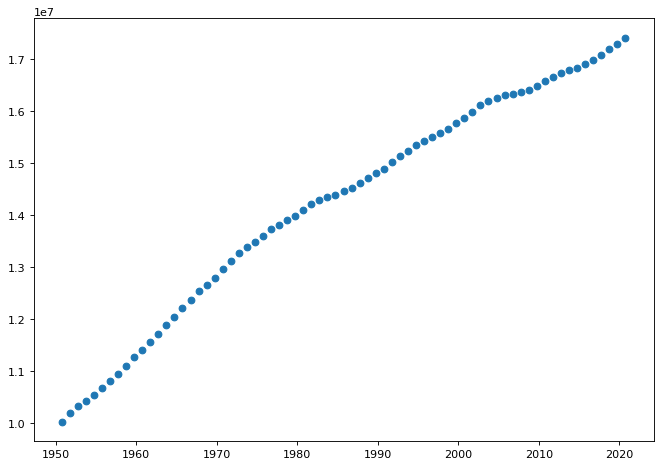

In [104]:
x = POP_NL.index
y = POP_NL.TotalPopulation_1

plt.scatter(x, y)
plt.show()

## Merge Data and create the modeling dataset

In [105]:
dataset_merged = Electricity_balance_quarterly.join(Weather_Quarterly, how='left', rsuffix='_Weather')
dataset_merged = dataset_merged.join(GDP_NL, how='left', rsuffix = '_GDP')
dataset_merged = dataset_merged.join(POP_NL, how='left', rsuffix = '_POP')

dataset_merged['Population'] = dataset_merged['TotalPopulation_1'].interpolate(method='polynomial', order=2)
dataset_merged.head(10)

,ID,Periods,GrossProduction_1,OwnConsumptionForElectrProduction_2,NetProductionTotal_3,NuclearEnergy_4,FuelsTotal_5,Coal_6,OilProducts_7,NaturalGas_8,Biomass_9,OtherFuelsNonRenewable_10,HydroPower_11,WindEnergyTotal_12,WindEnergyOnShore_13,WindEnergyOffShore_14,SolarPhotovoltaic_15,OtherSources_16,ImportsTotal_17,Belgium_18,Denmark_19,Germany_20,UnitedKingdom_21,Norway_22,ExportsTotal_23,Belgium_24,Denmark_25,Germany_26,UnitedKingdom_27,Norway_28,DistributionLosses_29,NetConsumptionCalculated_30,STN,YYYYMMDD,TG,TN,TX,LOCATION,INDICATOR,SUBJECT,...,TotalFirstGeneration_40,TotalWesternFirstGeneration_41,MiddleAndEasternEuropeanEUCountries_42,GIPSCountriesEuropeanUnion_43,OtherWesternBackground_44,TotalNonWestern_45,Morocco_46,FormerNethAntillesAndAruba_47,Suriname_48,Turkey_49,OtherNonWesternBackground_50,TotalSecondGeneration_51,TotalWesternSecondGeneration_52,MiddleAndEasternEuropeanEUCountries_53,GIPSCountriesEuropeanUnion_54,OtherWesternBackground_55,TotalNonWestern_56,Morocco_57,FormerNethAntillesAndAruba_58,Suriname_59,Turkey_60,OtherNonWesternBackground_61,TotalPrivateHouseholds_62,OnePersonHouseholds_63,MultiPersonHouseholds_64,AverageHouseholdSize_65,PopulationInInstitutionalHouseholds_66,TotalPopulationGrowth_67,TotalPopulationGrowthRate_68,LiveBirths_69,Deaths_70,NaturalIncrease_71,NaturalIncreaseRate_72,Immigration_73,EmigrationIncludingAdministrati_74,NetMigrationIncludingAdministrativ_75,NetMigrationIncludingAdminRate_76,OtherCorrections_77,PopulationDensity_78,Population
Period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1976-01-01,50,1976 1st quarter,14947.0,623.0,14324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,62,NaN,NaN,NaN,NaN,NaN,639.0,13639.0,260.0,1.976022e+07,33.593407,3.175824,64.736264,NLD,QGDP,TOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-04-01,54,1976 2nd quarter,13581.0,565.0,13016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,94,NaN,NaN,NaN,NaN,NaN,581.0,12343.0,260.0,1.976052e+07,129.087912,65.912088,185.813187,NLD,QGDP,TOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-07-01,58,1976 3rd quarter,13721.0,596.0,13125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,NaN,NaN,585.0,12464.0,260.0,1.976081e+07,170.619565,114.510870,225.358696,NLD,QGDP,TOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976-10-01,62,1976 4th quarter,15889.0,668.0,15221.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,87,NaN,NaN,NaN,NaN,NaN,679.0,14458.0,260.0,1.976112e+07,65.739130,36.456522,93.760870,NLD,QGDP,TOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4660.0,924.0,3737.0,2.90,NaN,80917.0,5.9,177090.0,114454.0,62636.0,4.5,82953.0,61530.0,21423.0,1.6,-3142.0,406.0,1.373358e+07
1977-01-01,67,1977 1st quarter,15361.0,637.0,14724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,58,NaN,NaN,NaN,NaN,NaN,661.0,14015.0,260.0,1.977022e+07,49.933333,18.566667,79.911111,NLD,QGDP,TOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375374e+07
1977-04-01,71,1977 2nd quarter,13816.0,620.0,13196.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,NaN,589.0,12748.0,260.0,1.977052e+07,110.670330,63.406593,154.461538,NLD,QGDP,TOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

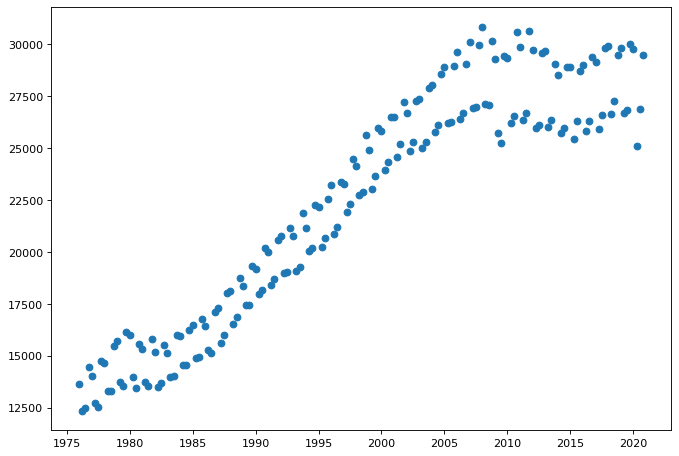

In [106]:
x = dataset_merged.index
y = dataset_merged.NetConsumptionCalculated_30

plt.scatter(x, y)
plt.show()

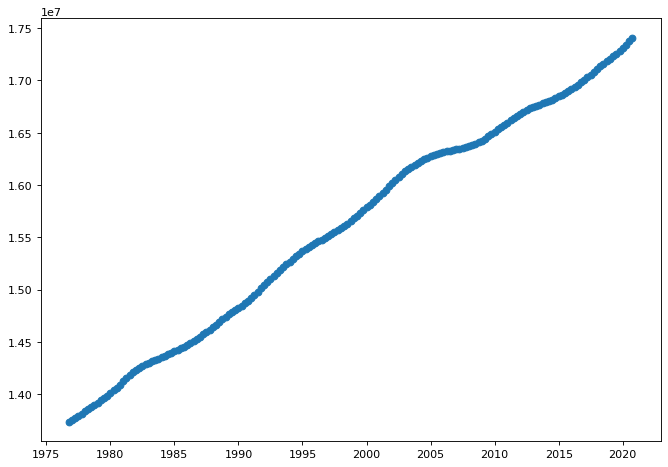

In [107]:
x = dataset_merged.index
y = dataset_merged.Population

plt.scatter(x, y)
plt.show()

In [108]:
Modeling_columns = ['Periods', 'NetConsumptionCalculated_30', 'TG', 'Value', 'Population']

modeling_dataset = dataset_merged[Modeling_columns]
modeling_dataset.tail(20)

,Periods,NetConsumptionCalculated_30,TG,Value,Population
Period,,,,,
2016-01-01,2016 1st quarter,28990.0,49.153846,0.916493,1.691945e+07
2016-04-01,2016 2nd quarter,25830.0,133.494505,0.232835,1.693788e+07
2016-07-01,2016 3rd quarter,26297.0,178.445652,1.122432,1.695732e+07
2016-10-01,2016 4th quarter,29397.0,66.695652,0.842837,1.697912e+07
2017-01-01,2017 1st quarter,29151.0,50.700000,0.507585,1.700308e+07
2017-04-01,2017 2nd quarter,25947.0,138.692308,0.881161,1.702862e+07
2017-07-01,2017 3rd quarter,26615.0,163.184783,0.727858,1.705521e+07
2017-10-01,2017 4th quarter,29844.0,85.086957,0.791995,1.708151e+07
2018-01-01,2018 1st quarter,29932.0,37.811111,0.457198,1.710722e+07


In [109]:
# Rename columns

modeling_dataset.rename(columns = {'NetConsumptionCalculated_30':'Electricity_Consumption', 'TG':'Avg_Temp',
                              'Value':'GDP_Change'}, inplace = True)

modeling_dataset.head(20)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Periods,Electricity_Consumption,Avg_Temp,GDP_Change,Population
Period,,,,,
1976-01-01,1976 1st quarter,13639.0,33.593407,0.188830,NaN
1976-04-01,1976 2nd quarter,12343.0,129.087912,0.099520,NaN
1976-07-01,1976 3rd quarter,12464.0,170.619565,3.533003,NaN
1976-10-01,1976 4th quarter,14458.0,65.739130,-1.692872,1.373358e+07
1977-01-01,1977 1st quarter,14015.0,49.933333,1.213842,1.375374e+07
1977-04-01,1977 2nd quarter,12748.0,110.670330,0.013692,1.377361e+07
1977-07-01,1977 3rd quarter,12552.0,155.228261,0.825347,1.379386e+07
1977-10-01,1977 4th quarter,14733.0,77.989130,0.997052,1.381450e+07
1978-01-01,1978 1st quarter,14654.0,36.266667,0.253524,1.383529e+07


In [110]:
#Normalize values

def minmax_norm(df_input):
    return (modeling_dataset['Avg_Temp'] - modeling_dataset['Avg_Temp'].min()) / (modeling_dataset['Avg_Temp'].max() - modeling_dataset['Avg_Temp'].min())

modeling_dataset['Avg_Temp_Norm'] = minmax_norm(modeling_dataset['Avg_Temp'])

def minmax_norm(df_input):
    return (modeling_dataset['GDP_Change'] - modeling_dataset['GDP_Change'].min()) / (modeling_dataset['GDP_Change'].max() - modeling_dataset['GDP_Change'].min())

modeling_dataset['GDP_Change_Norm'] = minmax_norm(modeling_dataset['GDP_Change'])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
modeling_dataset['Population_Norm'] = scaler.fit_transform(modeling_dataset['Population'].values.reshape(-1,1))

modeling_dataset['Consumption_Increase'] = np.where(modeling_dataset['Electricity_Consumption'].diff(periods = 1) > 0, 1, 0)

modeling_dataset = modeling_dataset.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [139]:
modeling_dataset.tail(20)

,Periods,Electricity_Consumption,Avg_Temp,GDP_Change,Population,Avg_Temp_Norm,GDP_Change_Norm,Population_Norm,Consumption_Increase
Period,,,,,,,,,
2015-10-01,2015 4th quarter,28715.0,97.989130,0.016288,1.690073e+07,0.514320,0.525235,0.862042,1
2016-01-01,2016 1st quarter,28990.0,49.153846,0.916493,1.691945e+07,0.252867,0.580481,0.867139,1
2016-04-01,2016 2nd quarter,25830.0,133.494505,0.232835,1.693788e+07,0.704408,0.538524,0.872155,0
2016-07-01,2016 3rd quarter,26297.0,178.445652,1.122432,1.695732e+07,0.945066,0.593119,0.877445,1
2016-10-01,2016 4th quarter,29397.0,66.695652,0.842837,1.697912e+07,0.346782,0.575961,0.883379,1
2017-01-01,2017 1st quarter,29151.0,50.700000,0.507585,1.700308e+07,0.261145,0.555386,0.889902,0
2017-04-01,2017 2nd quarter,25947.0,138.692308,0.881161,1.702862e+07,0.732235,0.578312,0.896852,0
2017-07-01,2017 3rd quarter,26615.0,163.184783,0.727858,1.705521e+07,0.863363,0.568904,0.904089,1
2017-10-01,2017 4th quarter,29844.0,85.086957,0.791995,1.708151e+07,0.445245,0.572840,0.911247,1


# Build the Model

In [147]:
#Define train and test sets

from sklearn.model_selection import train_test_split

Today        = modeling_dataset.index.max()
Input_vars   = ['Avg_Temp_Norm', 'GDP_Change_norm', 'Population_norm'] 
target       = 'Consumption_Increase'
x            = modeling_dataset[(modeling_dataset.index < Today)][['Avg_Temp_Norm','GDP_Change_Norm','Population_Norm', 'Consumption_Increase']] #Exclude today from the training set
y            = modeling_dataset[(modeling_dataset.index < Today)][target]
x_validation = modeling_dataset[(modeling_dataset.index == Today)][['Avg_Temp_Norm','GDP_Change_Norm','Population_Norm', 'Consumption_Increase']] #Define today as the validation set

#Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [148]:
#Predict using SVM

from sklearn.svm import SVC

#Train model

SVM = SVC(kernel='rbf',
            class_weight='balanced', #adjust weights inversely proportional to class frequency
            probability=True)
 
SVM.fit(x_train, y_train)

#Predict on testing set

y_pred_svm = SVM.predict(x_test)

<function matplotlib.pyplot.show>

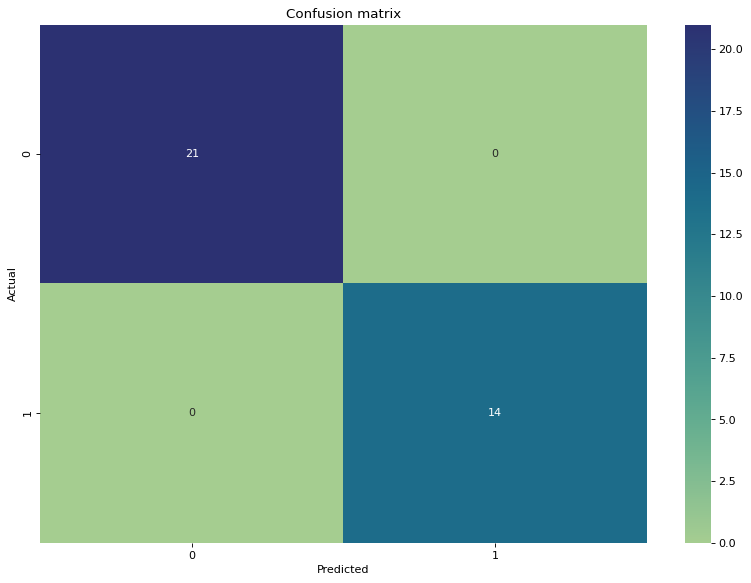

In [149]:
#Confusion matrix

#Metrics
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
from tabulate import tabulate

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_svm)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Create heatmap

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='crest', fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.rcParams['figure.dpi'] = 80
plt.rcParams["figure.figsize"] = (10, 7)
plt.show

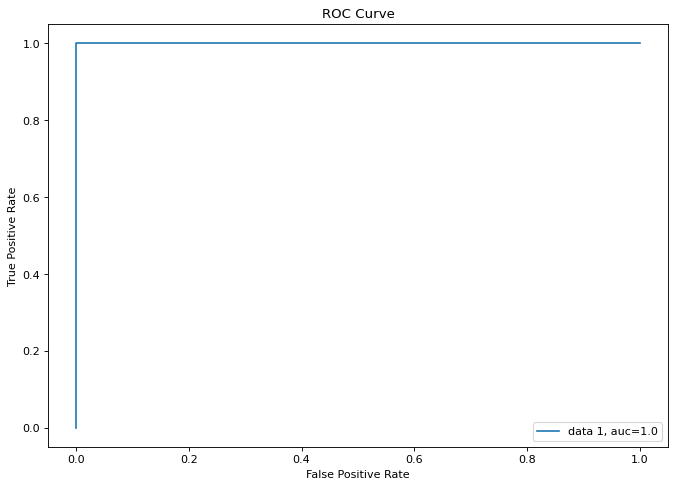

In [150]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_svm)
auc_svm = metrics.roc_auc_score(y_test, y_pred_svm)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc_svm))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [151]:
#SVM Evaluation metrics

#RMSE
rmse_svm = metrics.mean_squared_error(y_test, y_pred_svm, squared=False)

#AUC
auc_svm

#Accuracy
Accuracy_svm = metrics.accuracy_score(y_test, y_pred_svm)

#Precision
Precision_svm = metrics.precision_score(y_test, y_pred_svm)

#Recall
Recall_svm = metrics.recall_score(y_test, y_pred_svm)

#F-measure
F1_score_svm = metrics.f1_score(y_test, y_pred_svm)

#MCC
MCC_svm = metrics.matthews_corrcoef(y_test, y_pred_svm)

In [152]:
print(rmse_svm)
print(auc_svm)
print(Accuracy_svm)
print(Precision_svm)
print(Recall_svm)
print(F1_score_svm)
print(MCC_svm)

0.0
1.0
1.0
1.0
1.0
1.0
1.0
